In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import re

In [2]:
columns_to_drop = [
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
    'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
    'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
    'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK'
]
application_train = pd.read_csv('./data/application_train.csv')

application_train= application_train.drop(columns=columns_to_drop)

In [3]:
X_encoded = pd.get_dummies(application_train.drop('TARGET',axis=1), columns=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE'], drop_first=True)

X= X_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y = application_train.TARGET

# 0.95, 0.05, 0.05

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.05, random_state = 37)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 1/19, random_state = 37)

data_dmatrix = lgb.Dataset(data=X_train,label=y_train)

In [4]:
#  num_leaves = 2^(max_depth)
params = {
            'boosting_type': 'gbdt', 'is_unbalance' : True,
            'learning_rate': 0.1, 'reg_alpha' : 0, 'random_state' : 37, 
            'early_stopping_rounds':20, 'max_depth' : 5, 'num_leaves' : 31
            }

pipe_lgb = Pipeline([('scaler', StandardScaler()), ('lgb', lgb.LGBMClassifier(**params))])

t0 = time.time()
pipe_lgb.fit(X_train.values, y_train.values,
            lgb__eval_set = [(X_train.values, y_train.values), (X_test.values, y_test.values)],
            lgb__eval_names = ['train', 'val'],
            lgb__eval_metric = 'binary_error', 
            )
t1 = time.time()
y_pred = pipe_lgb.predict(X_test)
y_trainPred = pipe_lgb.predict(X_train)
print('LightGBM elapse time: {}'.format(t1-t0))

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 23492, number of negative: 267834
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3859
[LightGBM] [Info] Number of data points in the train set: 291326, number of used features: 135
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Accuracy may be bad s

c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LightGBM elapse time: 3.809063673019409


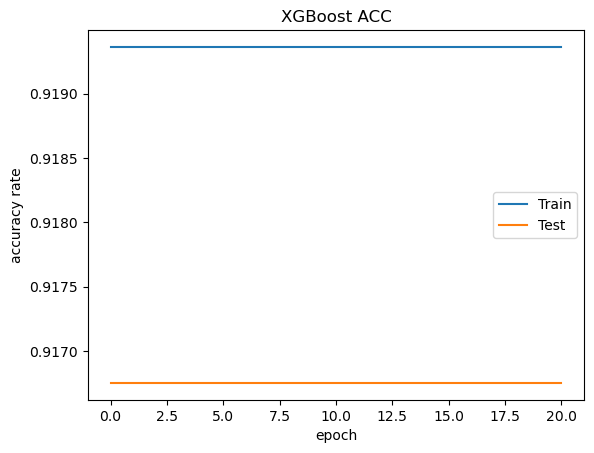

In [5]:
# accuracy=accuracy_score(y_pred, y_test)
# print('LightGBM Model test accuracy score: {0:0.4f}'.format(accuracy))

results = pipe_lgb.named_steps["lgb"].evals_result_
epochs = len(results['train']['binary_error'])
x_axis = range(0, epochs)
acc = [np.abs(x - 1) for x in results['train']['binary_error']]
acc2 = [np.abs(x - 1) for x in results['val']['binary_error']]
fig, ax = plt.subplots()
ax.plot(x_axis, acc, label='Train')
ax.plot(x_axis, acc2, label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy rate')
plt.title('XGBoost ACC')
plt.show()

In [6]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[14096     0]
 [ 1280     0]]

True Positives(TP) =  14096

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  1280


<Axes: >

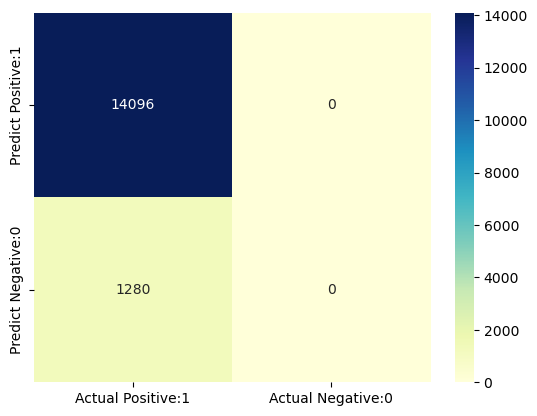

In [7]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     14096
           1       0.00      0.00      0.00      1280

    accuracy                           0.92     15376
   macro avg       0.46      0.50      0.48     15376
weighted avg       0.84      0.92      0.88     15376



c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


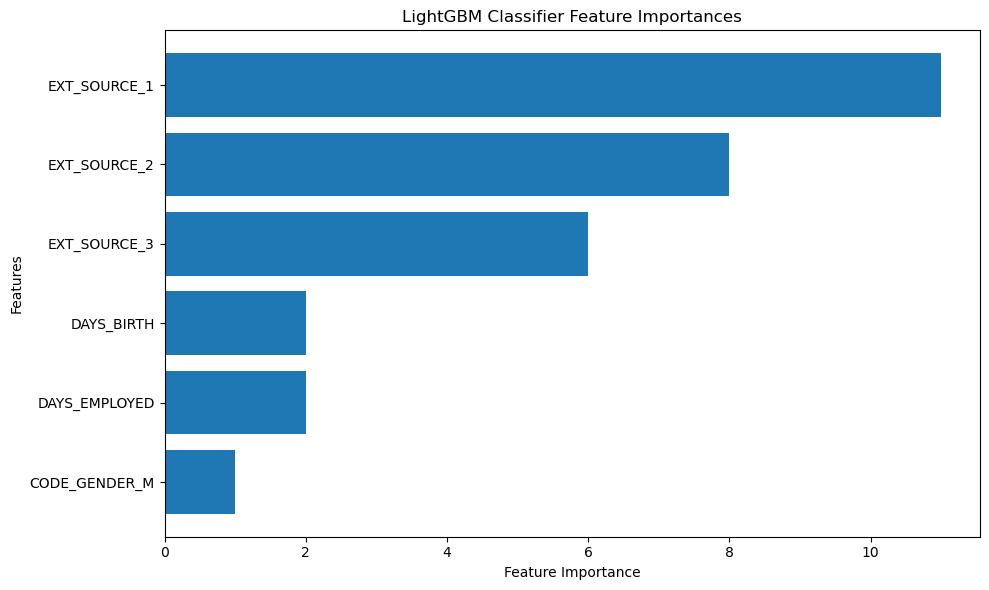

In [10]:
feature_importances = pipe_lgb.steps[1][1].feature_importances_
# Get feature names from the pipeline
feature_names = X_train.columns

# Sort feature importances in ascending order
sorted_indices = np.argsort(feature_importances)[::1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

important_indices = np.where(sorted_feature_importances != 0)[0]
important_feature_importances = sorted_feature_importances[important_indices]
important_feature_names = sorted_feature_names[important_indices]
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(important_feature_importances)), important_feature_importances, tick_label=important_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('LightGBM Classifier Feature Importances')
plt.tight_layout()
plt.show()